In [1]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# 1) Circuit construction

### 1.1) Parametrization

In [21]:
n_qubits = 3
shots = 1024

optimization_level = 0

token = ""
channel = "ibm_quantum"
instance = "ibm-q/open/main"

### 1.2) Circuit definition

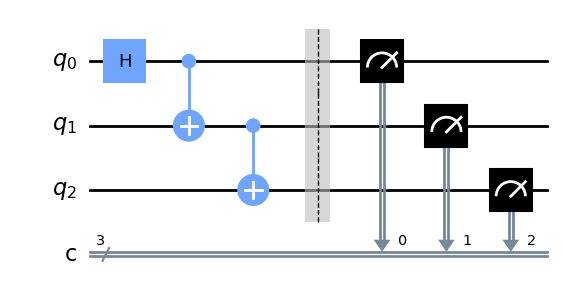

In [22]:
# Create a basic circuit

qr = QuantumRegister(n_qubits, "q")
cr = ClassicalRegister(n_qubits, "c")

qc = QuantumCircuit(qr, cr)

qc.h(0)
for i in range(n_qubits-1):
    qc.cx(i, i+1)

qc.barrier()

for i in range(n_qubits):
    qc.measure(i, i)

qc.draw("mpl", style="clifford")

# 2) Simulating the circuit

### 2.1) Running the circuit in a simulator

In [23]:
sampler = StatevectorSampler()
pub = (qc)
job = sampler.run([pub], shots=shots)
result = job.result()

### 2.2) Postprocessing the results

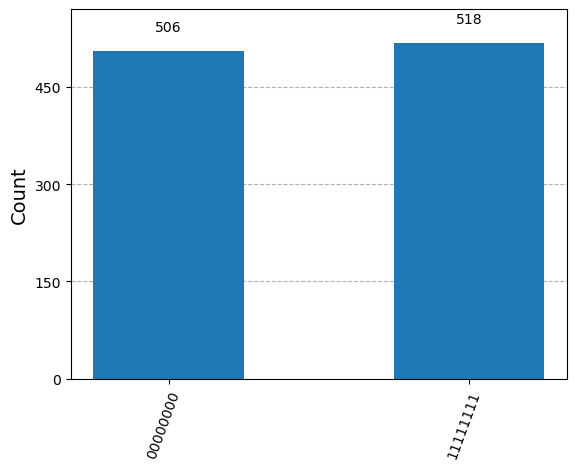

In [20]:
counts = result[0].data.c.array

hist = {}

for i in range(len(counts)):

    x_binary = "".join([bin(counts[i][j])[2:] for j in range(len(counts[i]))]).zfill(n_qubits)

    hist[x_binary] = hist.get(x_binary, 0) + 1

plot_histogram(hist)

# 3) Running the circuit in real hardware

### 3.1) (Optional) Save you API token

In [7]:
if token != "":

    QiskitRuntimeService.save_account(
        token=token,
        channel=channel,
        overwrite=True
    )

### 3.2) Selecting the best backend

In [8]:
service = QiskitRuntimeService(channel=channel, instance=instance)
backend = service.least_busy(operational=True, min_num_qubits=n_qubits)

print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"Qubits: {backend.num_qubits}\n"
)

Name: ibm_brisbane
Version: 2
Qubits: 127



### 3.3) Preparing the ISA circuit for the selected backend

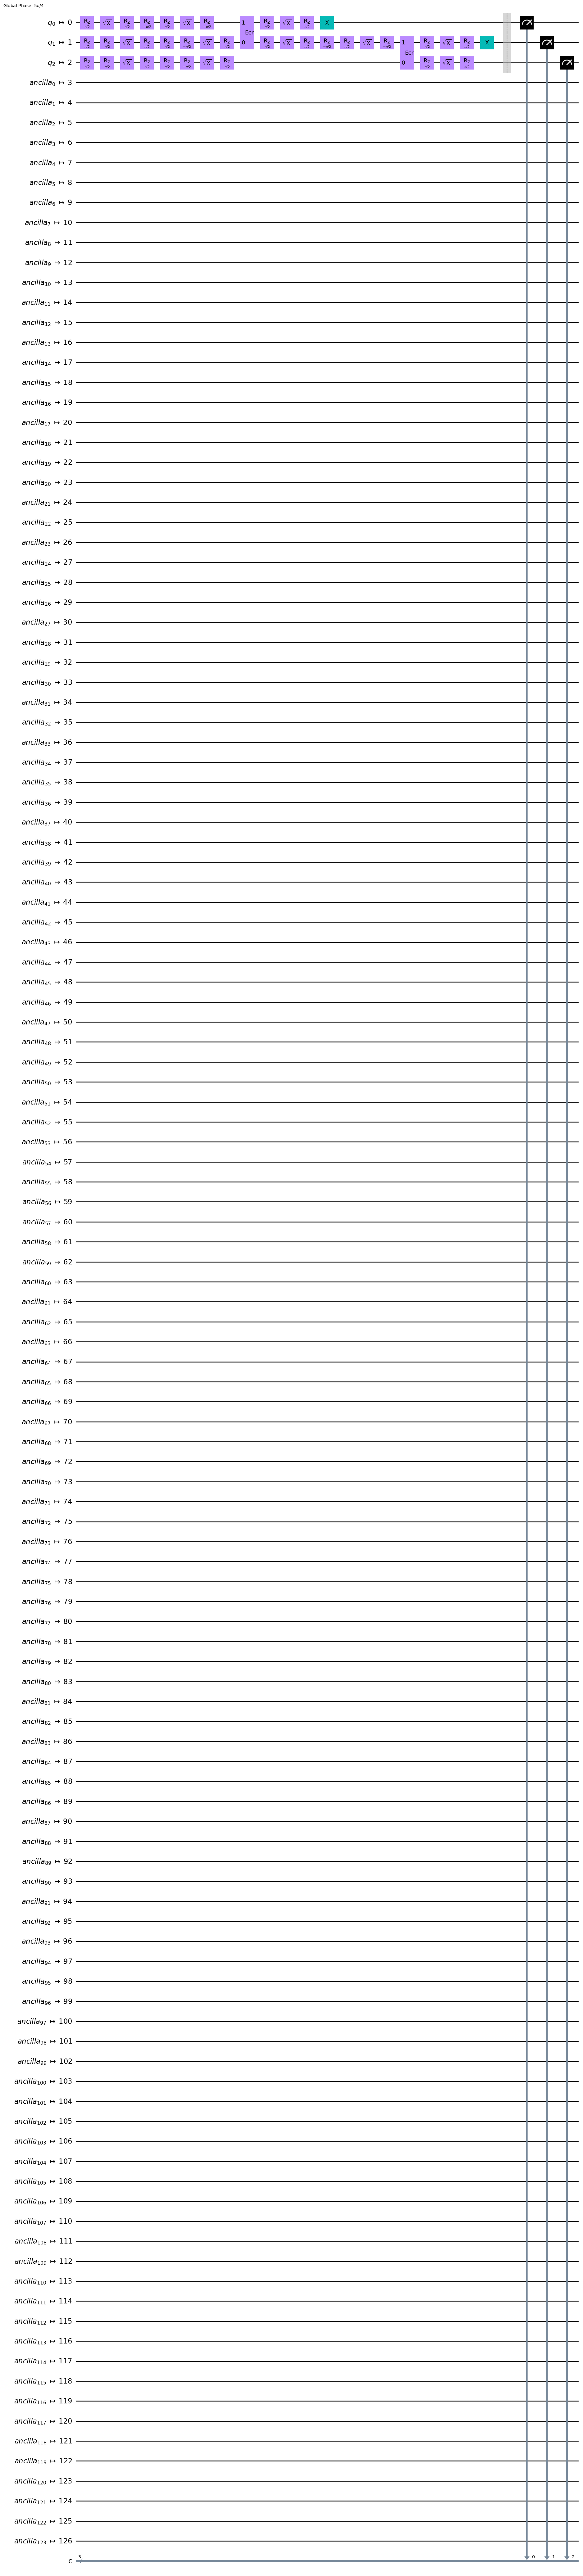

In [9]:
target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", style="clifford")

### 3.4) Posting a job to the selected backend

In [10]:
sampler = Sampler(backend=backend)
    
job = sampler.run([isa_circuit], shots=shots)
job_id = job.job_id()
print("Job ID: ", job_id)

Job ID:  cyt48ykjj6dg008e6e20


### 3.5) Retrieving the job from the ID (optional)

In [11]:
job = service.job(job_id)

### 3.6) Checking from code the job status

In [16]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [13]:
job.done()

False

### 3.7) Post-processing the results

In [14]:
result = job.result()

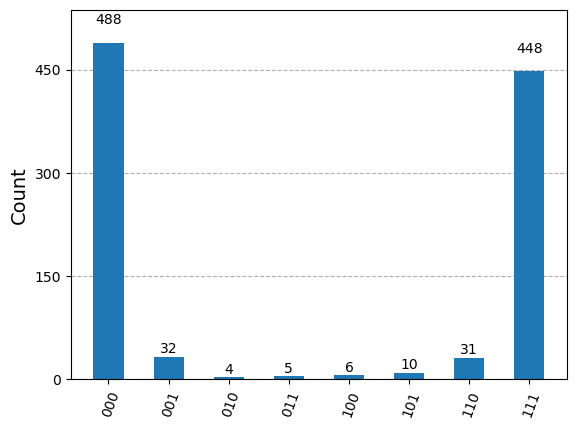

In [15]:
try:
    counts = result[0].data.c.array # c es el nombre que le hemos dado al registro clásico, 'meas' por defecto
except:
    counts = result[0]["__value__"]["data"]["c"].array

hist = {}

for i in range(len(counts)):

    x_binary = "".join([bin(counts[i][j])[2:] for j in range(len(counts[i]))]).zfill(n_qubits)

    hist[x_binary] = hist.get(x_binary, 0) + 1

plot_histogram(hist)